In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, PeftModel

model_name = "unsloth/Llama-3.2-1B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(model_name)

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj","v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

peft_model = get_peft_model(base_model, peft_config)
peft_model.print_trainable_parameters()

/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.0689


In [3]:
peft_model.merge_adapter()
peft_model.print_trainable_parameters()

trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.0689


In [4]:
peft_model = get_peft_model(base_model, peft_config, 'other_lora')
peft_model.print_trainable_parameters()

trainable params: 851,968 || all params: 1,237,518,336 || trainable%: 0.0688


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/tuners/lora/model.py:431: UserWarning: Adapter cannot be set when the model is merged. Unmerging the model first.
  warnings.warn("Adapter cannot be set when the model is merged. Unmerging the model first.")


In [5]:
peft_model.unmerge_adapter()
peft_model.print_trainable_parameters()

trainable params: 851,968 || all params: 1,237,518,336 || trainable%: 0.0688


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/peft/tuners/lora/layer.py:544: UserWarning: Already unmerged. Nothing to do.
  warnings.warn("Already unmerged. Nothing to do.")


In [6]:
model_name = "unsloth/Llama-3.2-1B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(model_name)

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj","v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

peft_model = get_peft_model(base_model, peft_config)

In [7]:
import os
import glob

clients = [i for i in range(20)]
c_params = [[] for i in range(20)]

for c in clients:
    path = f'output_multitask/Llama-3.2-1B/feddpa-1domain_multitask_clustered_c20s5_i5_b16a1_l1024_r8a16_20250407111210/local_adapters/checkpoint-*_client{c}'
    ckpts = glob.glob(path)
    latest_ckpt = max(ckpts, key=os.path.getctime)

    latest_ckpt = latest_ckpt + '/local'
    peft_model = PeftModel.from_pretrained(
        base_model,
        latest_ckpt,
        adapter_name='local',
    )
    #get adapter parameters
    for name, param in peft_model.named_parameters():
        if 'lora_B.local' in name:
            print(name)
            c_params[c].append(param.data)
        

base_model.model.model.layers.0.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.1.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.1.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.2.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.2.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.3.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.3.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.4.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.4.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.5.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.5.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.6.self_attn.q_proj.lora_B.local.weight
base_model.model.model.layers.6.self_attn.v_proj.lora_B.local.weight
base_model.model.model.layers.7.se

<Axes: >

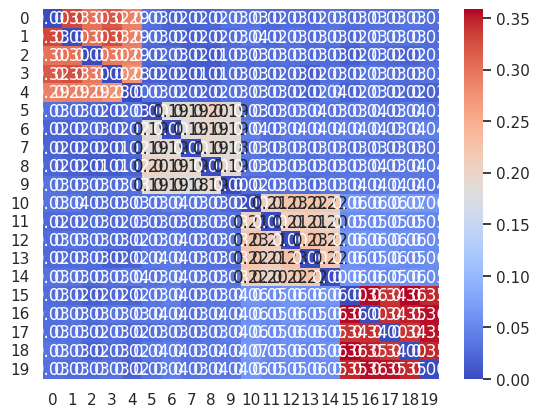

In [8]:
#similarity betweem adapters

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#flatten the list of parameters
c_params = [np.concatenate([p.flatten().cpu().numpy() for p in params]) for params in c_params]

sims = np.zeros((len(clients), len(clients)))
for i in range(len(clients)):
    for j in range(i+1, len(clients)):
        sims[i][j] = cosine_similarity(c_params[i].reshape(1, -1), c_params[j].reshape(1, -1))[0][0]
        sims[j][i] = sims[i][j]

sns.heatmap(sims, cmap='coolwarm', annot=True, fmt='.2f', xticklabels=clients, yticklabels=clients)

In [11]:
centroids

array([[ 10.43022352, -15.42905054],
       [-24.2343432 ,   2.87201758],
       [  1.71872936,  -7.54514579],
       [ 12.10791401,  20.09509622],
       [  1.66242013,  -7.52743946]])

In [10]:
[[i]*n_client_clusters for i in range(int(len(embeddings.keys())))]

[[0, 0],
 [1, 1],
 [2, 2],
 [3, 3],
 [4, 4],
 [5, 5],
 [6, 6],
 [7, 7],
 [8, 8],
 [9, 9],
 [10, 10],
 [11, 11],
 [12, 12],
 [13, 13],
 [14, 14],
 [15, 15],
 [16, 16],
 [17, 17],
 [18, 18],
 [19, 19]]

[2 3 2 3 2 3 3 2 2 3 2 1 2 1 1 2 1 2 1 2 1 0 0 1 0 1 0 1 0 1 0 3 0 3 0 3 0
 3 3 0]


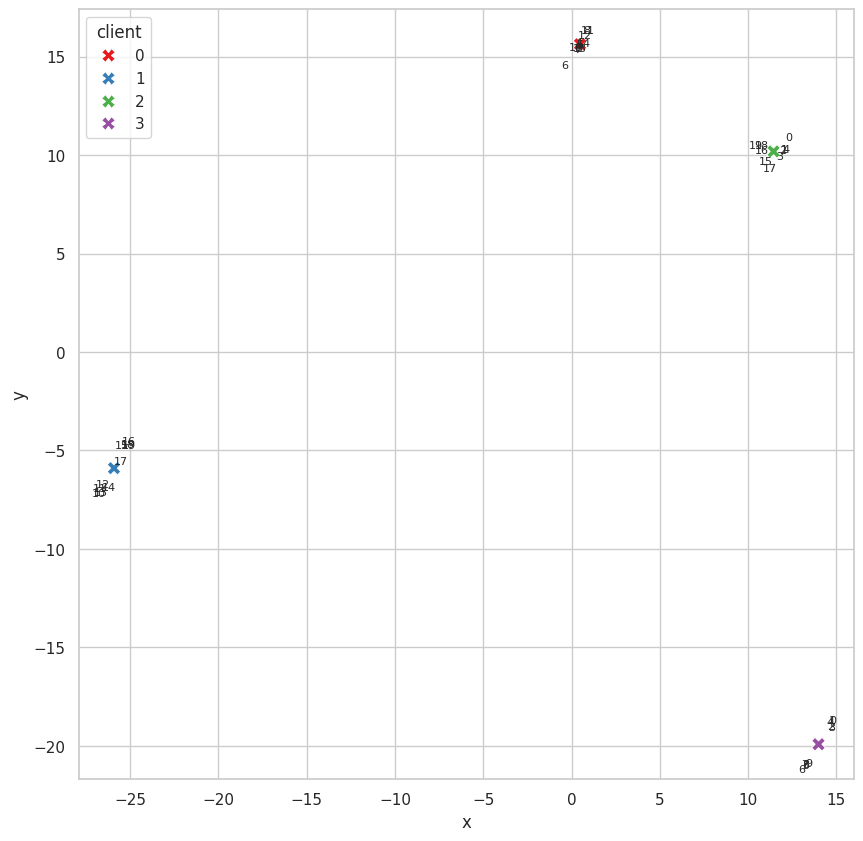

In [17]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

n_client_clusters = 2

for i in range(1, 2):
    path_c_embed = base_path + f'/centers/client_embeddings_{i}.npy'
    path_centroid = base_path + f'/centers/centroids_{i}.npy'

    embeddings = np.load(path_c_embed, allow_pickle=True)
    embeddings = embeddings.tolist()

    client_centroids = []
    for key in embeddings.keys():
        for j in embeddings[key]:
            client_centroids.append(j)
    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(client_centroids)
    df = pd.DataFrame(pca_result, columns=['x', 'y'])
    df['client'] = np.array([[key]*n_client_clusters for key in range(len(embeddings.keys()))]).flatten()

    # Plot: annotate each point with the client number
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 10))
    for idx, row in df.iterrows():
         plt.text(row['x'], row['y'], str(int(row['client'])), fontsize=8, ha='center', va='center')

    centroids = np.load(path_centroid, allow_pickle=True)

    # Plot centroids in PCA
    centroids = centroids.tolist()
    centroids = pca.transform(centroids)
    df_centroids = pd.DataFrame(centroids, columns=['x', 'y'])
    df_centroids['client'] = [i for i in range(len(centroids))]
    df_centroids['client'] = df_centroids['client'].astype('category')
    sns.scatterplot(x='x', y='y', hue='client', data=df_centroids, palette='Set1', marker='X', s=100)

    kmeans = KMeans(n_clusters=4, random_state=0).fit(client_centroids)
    print(kmeans.labels_)



In [ ]:
client_centroids

#apply k menas in client centroids
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=4, random_state=0).fit(client_centroids)
kmeans.labels_


array([1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 0, 3, 0, 3, 3, 0, 0, 3, 0, 3, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2], dtype=int32)

In [ ]:
client_centroids

#apply k menas in client centroids
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=4, random_state=0).fit(client_centroids)
kmeans.labels_


array([1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 0, 3, 0, 3, 3, 0, 0, 3, 0, 3, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2], dtype=int32)